In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [75]:
data=pd.read_csv("Co2.csv")
data.head(5)

,Year,Month,Day,Decimal_Year,CO2_Concentration
0,1974,5,17,1974.3740,333.38
1,1974,5,18,1974.3767,333.11
2,1974,5,19,1974.3795,333.46
3,1974,5,20,1974.3822,333.64
4,1974,5,21,1974.3849,333.50


# PreProcessing

In [76]:
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Year                 0
Month                0
Day                  0
Decimal_Year         0
CO2_Concentration    0
dtype: int64


In [77]:
print("\nSummary statistics:")
print(data.describe())


Summary statistics:
               Year         Month           Day  Decimal_Year  \
count  15339.000000  15339.000000  15339.000000  15339.000000   
mean    1999.827303      6.467697     15.758654   2000.322804   
std       14.131846      3.491143      8.797843     14.129552   
min     1974.000000      1.000000      1.000000   1974.374000   
25%     1988.000000      3.000000      8.000000   1988.879750   
50%     2000.000000      6.000000     16.000000   2000.534200   
75%     2012.000000     10.000000     23.000000   2012.486350   
max     2024.000000     12.000000     31.000000   2024.334700   

       CO2_Concentration  
count       15339.000000  
mean          372.833687  
std            26.403897  
min           326.060000  
25%           351.820000  
50%           370.000000  
75%           394.040000  
max           428.590000  


In [7]:
# Check data types and missing values
print("\nData types and missing values:")
print(data.info())


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                   

In [87]:
# Convert 'Year', 'Month', and 'Day' columns to datetime format
data['date'] = pd.to_datetime(data[['Year', 'Month', 'Day']], utc=True)

# Drop unnecessary columns
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Replace month names with month numbers (optional step as per the provided dataset format)
data['date'] = data['date'].dt.strftime('%d-%m-%y')

# Display the first few rows of the modified dataset
print(data.head())


   Decimal_Year  CO2_Concentration      date
0      0.000000           0.071394  17-05-74
1      0.000054           0.068760  18-05-74
2      0.000110           0.072174  19-05-74
3      0.000164           0.073930  20-05-74
4      0.000218           0.072564  21-05-74


In [92]:
# missing values
numerical_columns = data.select_dtypes(include='number').columns
data_filled = data.copy()
data_filled[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())
data[numerical_columns]=data_filled[numerical_columns] 


In [93]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define the numerical columns
numerical_columns = ['Decimal_Year', 'CO2_Concentration']

# Remove commas from numerical columns
data[numerical_columns] = data[numerical_columns].replace(',', '', regex=True)

# Convert numerical columns to float
data[numerical_columns] = data[numerical_columns].astype(float)

# Initialize MinMaxScaler
min_max_scaler = MinMaxScaler()

# Normalize selected columns
data[numerical_columns] = min_max_scaler.fit_transform(data[numerical_columns])

# Display the normalized DataFrame
print(data)


       Decimal_Year  CO2_Concentration      date
0          0.000000           0.071394  17-05-74
1          0.000054           0.068760  18-05-74
2          0.000110           0.072174  19-05-74
3          0.000164           0.073930  20-05-74
4          0.000218           0.072564  21-05-74
...             ...                ...       ...
15334      0.999782           0.988784  28-04-24
15335      0.999836           0.973276  29-04-24
15336      0.999890           0.972106  30-04-24
15337      0.999946           0.978055  01-05-24
15338      1.000000           0.988784  02-05-24

[15339 rows x 3 columns]


In [94]:
from statsmodels.tsa.stattools import adfuller

# Select numerical columns
numerical_columns =  ['Decimal_Year', 'CO2_Concentration']

# Perform the Augmented Dickey-Fuller test for each numerical column
for column in numerical_columns:
    # Check if the column is constant
    if data[column].nunique() == 1:
        print(f"Skipping ADF test for column '{column}' because it is constant.")
        continue
    # Check for missing or infinite values
    if data[column].isnull().any() or data[column].isin([np.inf, -np.inf]).any():
        print(f"Skipping ADF test for column '{column}' due to missing or infinite values.")
        continue
    
    # Perform the ADF test
    adf_result = adfuller(data[column])
    
    # Extracting test statistics and p-value
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    
    # Print the results
    print(f'Column: {column}')
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    
    # Interpret the results
    if p_value < 0.05:
        print("Reject the null hypothesis (H0): The data is stationary.")
    else:
        print("Fail to reject the null hypothesis (H0): The data is non-stationary.")
    print()


Column: Decimal_Year
ADF Statistic: -5.620982576121819
p-value: 1.1453002229649622e-06
Reject the null hypothesis (H0): The data is stationary.

Column: CO2_Concentration
ADF Statistic: -0.8420468036586161
p-value: 0.8064581607825125
Fail to reject the null hypothesis (H0): The data is non-stationary.



In [95]:
def adf_test(series):
    if len(series.dropna()) < 2:
        print("Insufficient observations for ADF test.")
        return
    
    result = adfuller(series.dropna())
    
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] < 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")


# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Select numerical columns for preprocessing
numerical_columns =  ['Decimal_Year', 'CO2_Concentration']
print(df[numerical_columns])

# Replace zero values with a small positive constant
df[numerical_columns] = df[numerical_columns].replace(0, 1e-6)

# Apply logarithmic transformation
df[numerical_columns] = np.log(df[numerical_columns])

# Differencing
data_stationary = df.copy()
data_stationary[numerical_columns] = data_stationary[numerical_columns].diff()

# Drop the first row since differencing introduces NaN for the first row
#data_stationary = data_stationary.dropna()

# Apply ADF test for each numerical column
for column in numerical_columns:
    print(f"\nADF Test for differenced column '{column}':")
    adf_test(data_stationary[column])


       Decimal_Year  CO2_Concentration
0          0.000000           0.071394
1          0.000054           0.068760
2          0.000110           0.072174
3          0.000164           0.073930
4          0.000218           0.072564
...             ...                ...
15334      0.999782           0.988784
15335      0.999836           0.973276
15336      0.999890           0.972106
15337      0.999946           0.978055
15338      1.000000           0.988784

[15339 rows x 2 columns]

ADF Test for differenced column 'Decimal_Year':
ADF Statistic: -26.143550646186764
p-value: 0.0
Critical Values:
	1%: -3.430777644690348
	5%: -2.8617290007200062
	10%: -2.5668706004751405
The series is likely stationary.

ADF Test for differenced column 'CO2_Concentration':
ADF Statistic: -16.574972979418018
p-value: 1.8558769810199732e-29
Critical Values:
	1%: -3.430777616725883
	5%: -2.861728988361795
	10%: -2.5668705938970113
The series is likely stationary.


In [96]:
print(data_stationary)
data_stationary.to_csv('data_stationary2.csv', index=False)

       Decimal_Year  CO2_Concentration      date
0               NaN                NaN  17-05-74
1          3.989770          -0.037583  18-05-74
2          0.711496           0.048452  19-05-74
3          0.399386           0.024033  20-05-74
4          0.284629          -0.018642  21-05-74
...             ...                ...       ...
15334      0.000110          -0.011280  28-04-24
15335      0.000054          -0.015808  29-04-24
15336      0.000054          -0.001203  30-04-24
15337      0.000056           0.006102  01-05-24
15338      0.000054           0.010910  02-05-24

[15339 rows x 3 columns]


# Mysql connection

In [64]:
import pandas as pd
import mysql.connector

try:
    # Establish connection to MySQL database
    connection = mysql.connector.connect(
        host='localhost',
        port='3306',
        user='root',
        password='root',
        database='Co2_concentration'
    )
    cursor = connection.cursor()

    # Read the dataset from CSV file
    df = pd.read_csv('data_stationary2.csv')

    # Iterate through the dataset and insert into the database
    for index, row in df.iterrows():
        # Extracting data from each row
        date = row[date]
        CO2_Concentration = row['CO2_Concentration']
        Decimal_Year = row['Decimal_Year']


        # Insert data into the table
        insert_query = """
                    INSERT INTO concentration (time, generation_biomass, generation_fossil_coal_gas)
                    VALUES (%s, %s, %s)
                    """
        values = (date, CO2_Concentration, Decimal_Year)
        cursor.execute(insert_query, values)

    # Commit the transaction
    connection.commit()

    # Close the cursor and connection
    cursor.close()
    connection.close()

except mysql.connector.Error as error:
    print("Error inserting data into MySQL table:", error)



Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')
Error inserting data into MySQL table: 1054 (42S22): Unknown colum

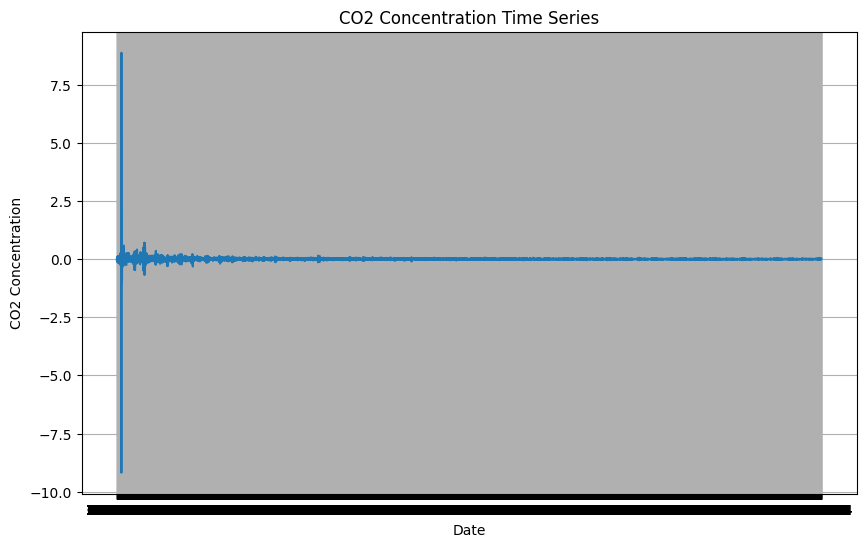

In [100]:
data = pd.read_csv('data_stationary2.csv')
# Plot the Close pricing of the stock time series data
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['CO2_Concentration'])
plt.title('CO2 Concentration Time Series')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration')
plt.grid(True)
plt.show()

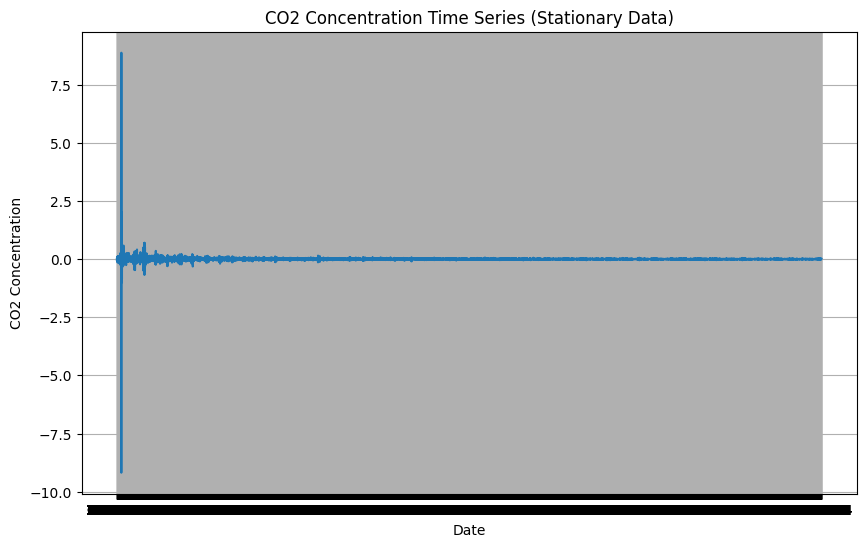

In [101]:
# Plot the Close pricing of the stock time series stationary data
plt.figure(figsize=(10, 6))
plt.plot(data_stationary['date'], data_stationary['CO2_Concentration'])
plt.title('CO2 Concentration Time Series (Stationary Data)')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration')
plt.grid(True)
plt.show()

# ARIMA

ADF Statistic: -16.573720180248646
p-value: 1.8604165160247334e-29
Critical Values:
   1%: -3.4307775887650753
   5%: -2.8617289760051996
   10%: -2.5668705873197424


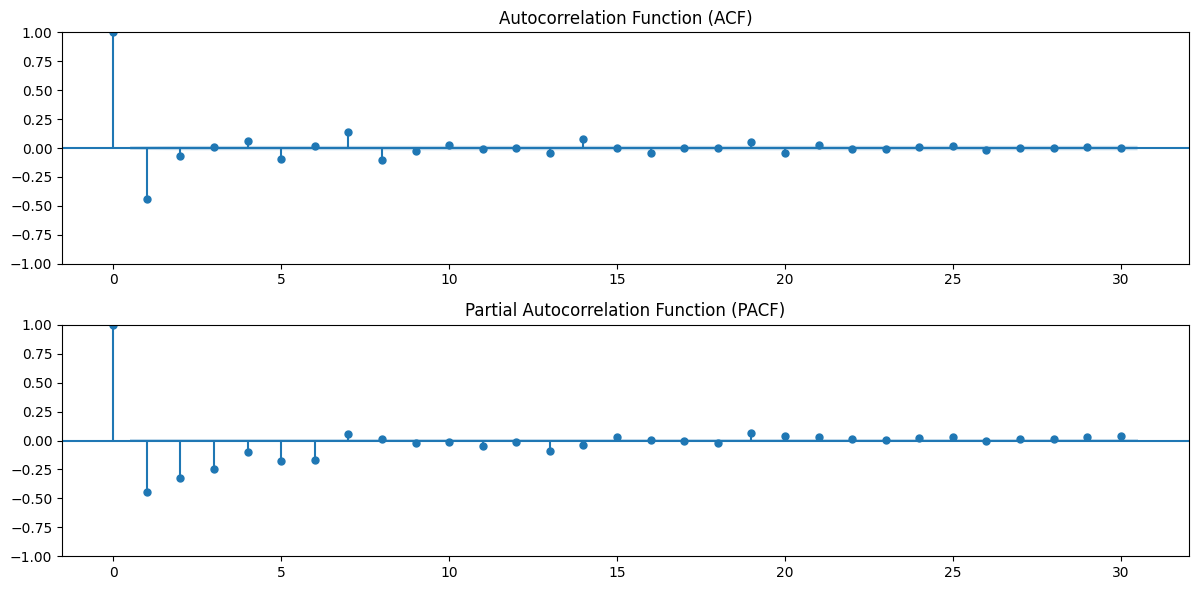

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the dataset
data_stationary = pd.read_csv('data_stationary2.csv')

# Define a function to perform the ADF test
def adf_test(timeseries):
    # Remove null values from the time series
    timeseries = timeseries.fillna(timeseries.mean())
    
    # Check if there are still enough data points after removing null values
    if len(timeseries) < 2:
        print("Insufficient data points after removing null values.")
        return
    
    # Perform the ADF test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Perform ADF test to determine order of differencing
adf_test(data_stationary['CO2_Concentration'])

# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data_stationary['CO2_Concentration'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.subplot(212)
plot_pacf(data_stationary['CO2_Concentration'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


In [105]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
data_stationary = pd.read_csv('data_stationary2.csv')

# Example values for p, d, and q
p_values = range(0, 3)  # Try values from 0 to 2
d_values = range(0, 2)  # Try values 0 and 1
q_values = range(0, 3)  # Try values from 0 to 2

best_aic = np.inf
best_pdq = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(data_stationary['CO2_Concentration'], order=(p, d, q))
                results = model.fit()
                aic = results.aic
                if aic < best_aic:
                    best_aic = aic
                    best_pdq = (p, d, q)
            except:
                continue

print("Best AIC:", best_aic)
print("Best (p, d, q):", best_pdq)


C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starti

Best AIC: -30499.296773706275
Best (p, d, q): (2, 0, 1)


C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


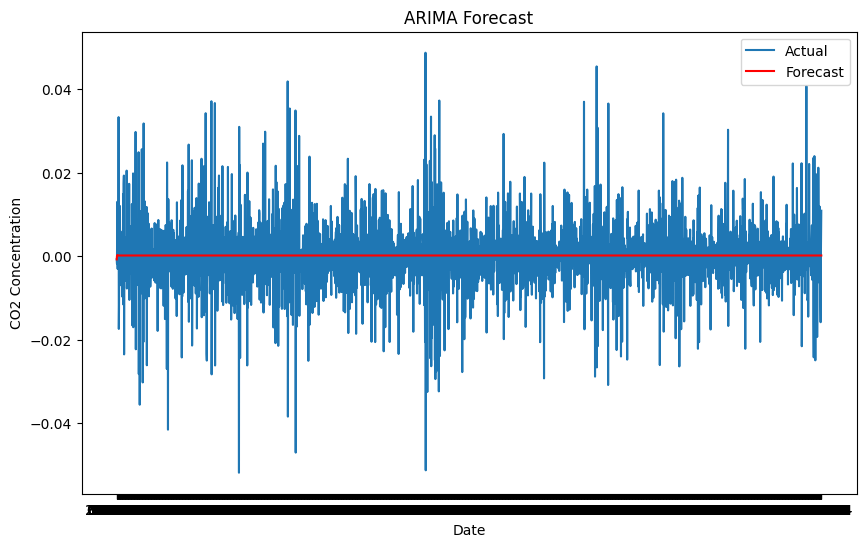

Mean Absolute Error (MAE): 0.005387003868873449
Mean Squared Error (MSE): 6.604303252121346e-05
Root Mean Squared Error (RMSE): 0.008126686441669412


In [107]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load the dataset
data_stationary = pd.read_csv('data_stationary2.csv')

# Split the data into features (X) and target variable (y)
X = data_stationary.drop(columns=['CO2_Concentration']) 
y = data_stationary['CO2_Concentration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit ARIMA model
order = (1, 0, 2)  # Example values for p, d, q
model = ARIMA(y_train, order=order)
fit_model = model.fit()

# Forecast
forecast = fit_model.forecast(steps=len(y_test))

# Plot the actual vs. forecasted values
plt.figure(figsize=(10, 6))
plt.plot(X_test['date'], y_test, label='Actual')
plt.plot(X_test['date'], forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration')
plt.legend()
plt.show()

# Evaluate the model
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


# Sarima

ADF Statistic for seasonal differencing: -25.97207938871091
p-value for seasonal differencing: 0.0


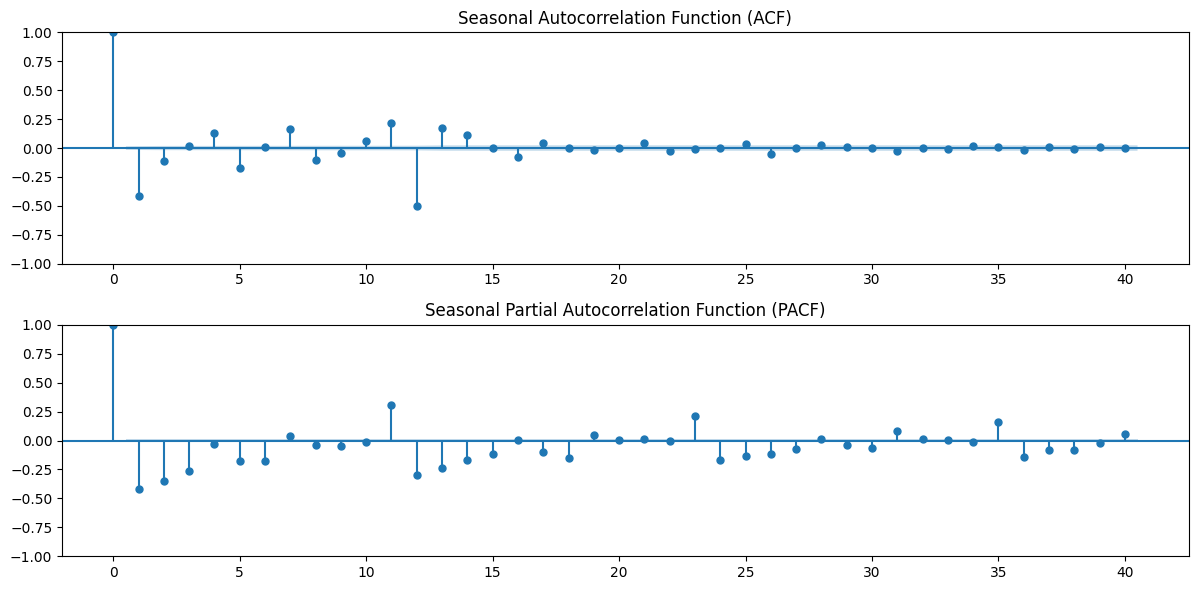

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the dataset
data_stationary = pd.read_csv('data_stationary2.csv')

# Perform seasonal differencing
seasonal_diff = data_stationary['CO2_Concentration'].diff(periods=12).dropna()

# Determine seasonal order of differencing (D) using ADF test
result = adfuller(seasonal_diff)
print('ADF Statistic for seasonal differencing:', result[0])
print('p-value for seasonal differencing:', result[1])

# Plot seasonal ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(seasonal_diff, ax=plt.gca(), lags=40)
plt.title('Seasonal Autocorrelation Function (ACF)')
plt.subplot(212)
plot_pacf(seasonal_diff, ax=plt.gca(), lags=40)
plt.title('Seasonal Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


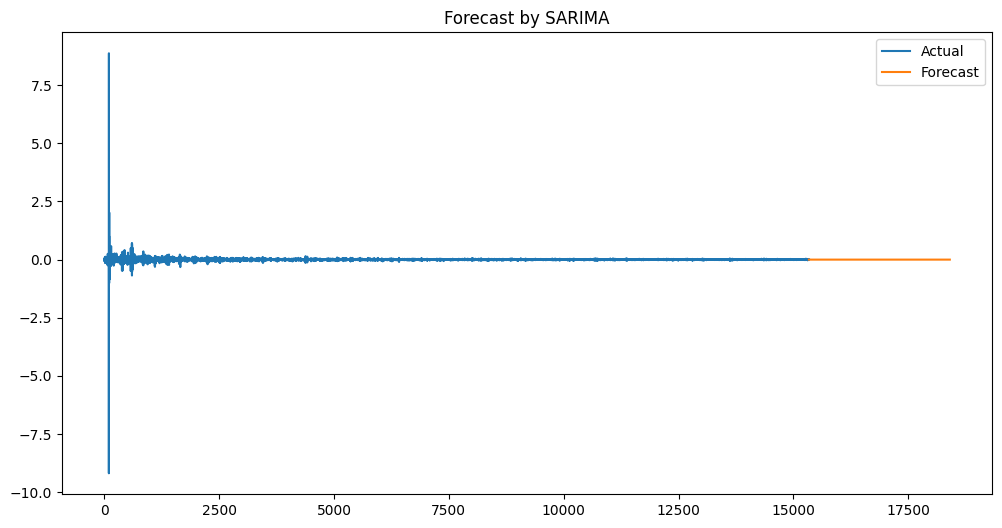

Mean Squared Error: 6.60518069048854e-05


In [109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define and fit SARIMAX model
model = SARIMAX(data_stationary['CO2_Concentration'], order=(0, 0, 0), seasonal_order=(0, 0, 0, 12))
results = model.fit()

# Forecast
forecast = results.get_forecast(steps=len(y_test))  # Adjust the forecast length as needed

# Plot forecast
plt.figure(figsize=(12, 6))
plt.title("Forecast by SARIMA")
plt.plot(data_stationary['CO2_Concentration'], label='Actual')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.legend()
plt.show()

# Evaluate model accuracy
actual_values = data_stationary['CO2_Concentration'][-len(forecast.predicted_mean):]
mse = mean_squared_error(actual_values, forecast.predicted_mean)
print("Mean Squared Error:", mse)


# ANN

In [110]:
# Convert X_train to DataFrame
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)


# Convert non-numeric values to numeric
X_train_numeric = X_train_df.apply(pd.to_numeric, errors='coerce')
X_test_numeric = X_test_df.apply(pd.to_numeric, errors='coerce')


# Check the data type of X_train_numeric
print("X_train_numeric data type:", X_train_numeric.dtypes)
print("X_train_numeric data type:", X_test_numeric.dtypes)

X_train_numeric data type: Decimal_Year    float64
date            float64
dtype: object
X_train_numeric data type: Decimal_Year    float64
date            float64
dtype: object


C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.8139e-04 - val_loss: 0.0116
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7465e-04 - val_loss: 0.0087
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7116e-04 - val_loss: 0.0028
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6734e-04 - val_loss: 0.3133
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7522e-04 - val_loss: 0.0013
Epoch 7/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6016e-06 - val_loss: 0.0010
Epoch 8/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3901e-05 - val_loss: 5.5948e-05
Epoch 9/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9063e-06 - val_loss: 0.0035
Epoch 10/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1964e-04 - val_loss: 0.0022
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021    
Test Loss: 0.0019785684999078512
96/96 ━━

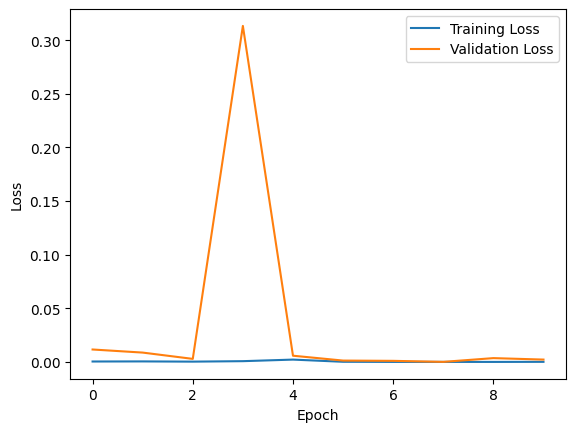

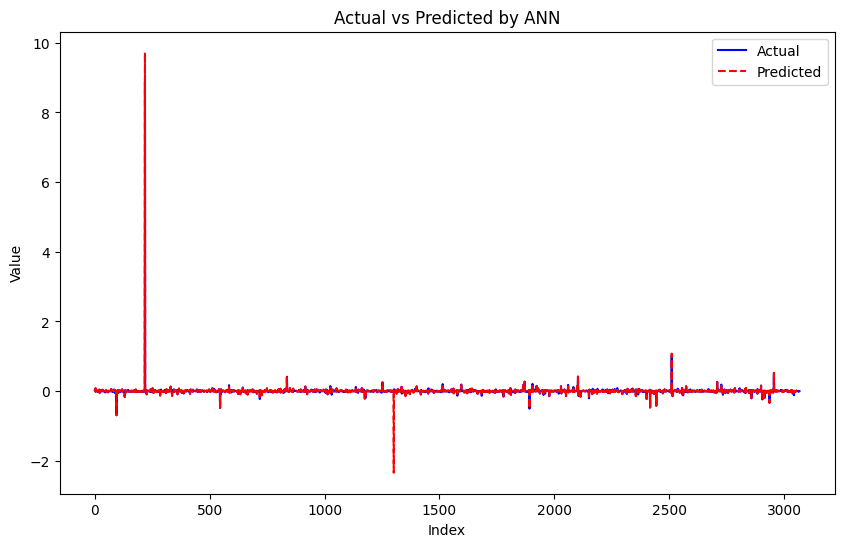

In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("data_stationary2.csv")

# Separate features and target variable
X = data.drop(columns=["date"])  # Exclude non-predictive columns
y = data["CO2_Concentration"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the ANN architecture
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer with linear activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)

# Make predictions
predictions = model.predict(X_test_scaled)

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted by ANN')
plt.legend()
plt.show()


# ETS

In [116]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
# Load your dataset
data = pd.read_csv("data_stationary2.csv")

# Simple Exponential Smoothing
model_simple = SimpleExpSmoothing(data['CO2_Concentration']).fit()
forecast_simple = model_simple.forecast(10)  # Forecast next 10 time steps

# Double Exponential Smoothing
model_double = ExponentialSmoothing(data['CO2_Concentration'], trend='add').fit()
forecast_double = model_double.forecast(10)  # Forecast next 10 time steps

# Triple Exponential Smoothing
model_triple = ExponentialSmoothing(data['CO2_Concentration'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_triple = model_triple.forecast(10)  # Forecast next 10 time steps

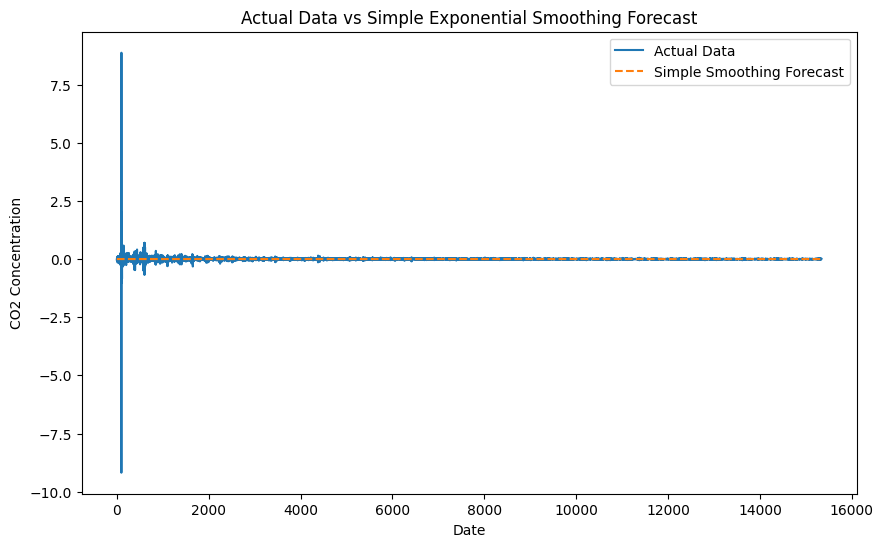

In [117]:
# Simple Exponential Smoothing
model_simple = SimpleExpSmoothing(data_stationary['CO2_Concentration']).fit()
forecast_simple = model_simple.forecast(len(data_stationary))  # Forecast for the entire time series

# Plotting actual data vs Simple Exponential Smoothing forecast
plt.figure(figsize=(10, 6))
plt.plot(data_stationary.index, data_stationary['CO2_Concentration'], label='Actual Data')
plt.plot(data_stationary.index, forecast_simple, label='Simple Smoothing Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration')
plt.title('Actual Data vs Simple Exponential Smoothing Forecast')
plt.legend()
plt.show()


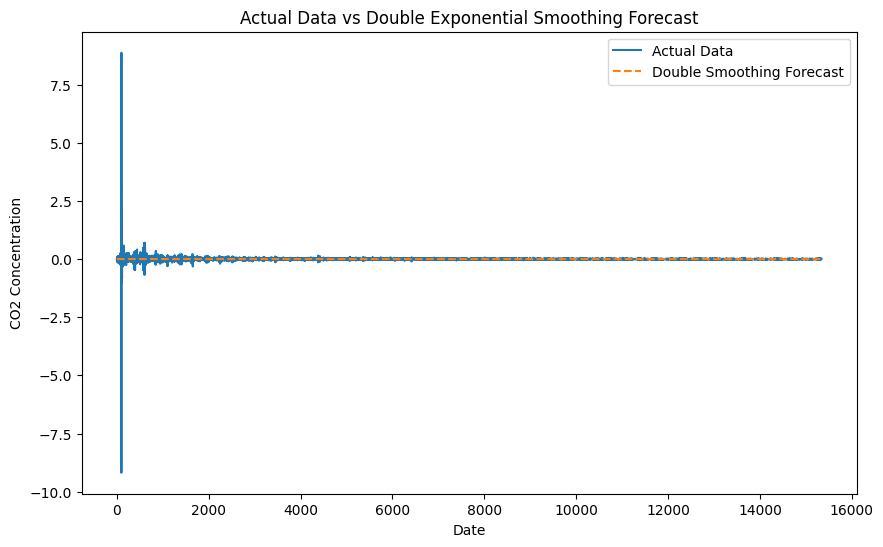

Accuracy Metrics for Double Exponential Smoothing:
MAE: 0.017083234513008083
MSE: 0.012404736979505216
RMSE: 0.11137655489152651
MAPE: inf


In [118]:
# Double Exponential Smoothing
model_double = ExponentialSmoothing(data_stationary['CO2_Concentration'], trend='add').fit()
forecast_double = model_double.fittedvalues  # Forecast for the entire time series

# Plotting actual data vs Double Exponential Smoothing forecast
plt.figure(figsize=(10, 6))
plt.plot(data_stationary.index, data_stationary['CO2_Concentration'], label='Actual Data')
plt.plot(data_stationary.index, forecast_double, label='Double Smoothing Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration')
plt.title('Actual Data vs Double Exponential Smoothing Forecast')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae_double = mean_absolute_error(data_stationary['CO2_Concentration'], forecast_double)

# Calculate Mean Squared Error (MSE)
mse_double = mean_squared_error(data_stationary['CO2_Concentration'], forecast_double)

# Calculate Root Mean Squared Error (RMSE)
rmse_double = np.sqrt(mse_double)

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_double = mean_absolute_percentage_error(data_stationary['CO2_Concentration'], forecast_double)

print("Accuracy Metrics for Double Exponential Smoothing:")
print("MAE:", mae_double)
print("MSE:", mse_double)
print("RMSE:", rmse_double)
print("MAPE:", mape_double)


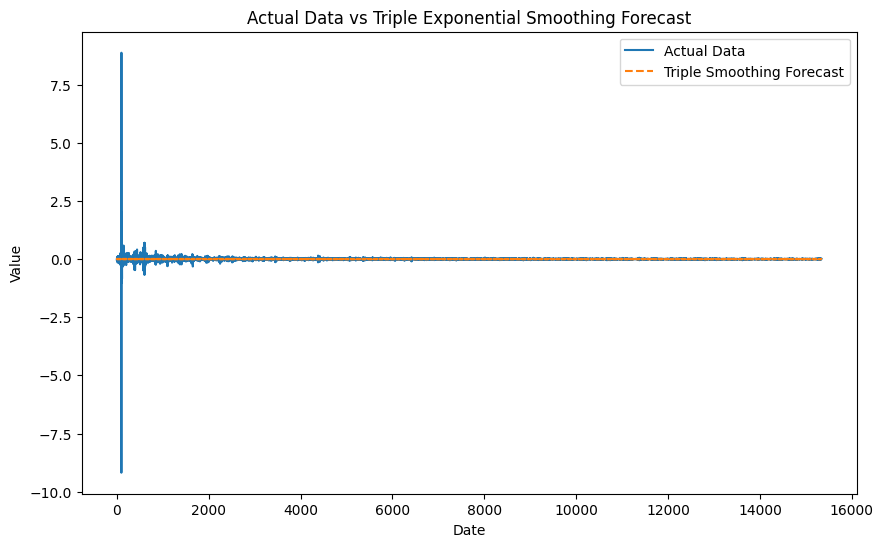

Accuracy Metrics for Triple Exponential Smoothing:
MAE: 0.017451988204864665
MSE: 0.012395250149366911
RMSE: 0.11133395775488676
MAPE: inf


In [120]:
# Triple Exponential Smoothing
model_triple = ExponentialSmoothing(data_stationary['CO2_Concentration'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_triple = model_triple.fittedvalues  # Forecast for the entire time series

# Plotting actual data vs Triple Exponential Smoothing forecast
plt.figure(figsize=(10, 6))
plt.plot(data_stationary.index, data_stationary['CO2_Concentration'], label='Actual Data')
plt.plot(data_stationary.index, forecast_triple, label='Triple Smoothing Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae_triple = mean_absolute_error(data_stationary['CO2_Concentration'], forecast_triple)

# Calculate Mean Squared Error (MSE)
mse_triple = mean_squared_error(data_stationary['CO2_Concentration'], forecast_triple)

# Calculate Root Mean Squared Error (RMSE)
rmse_triple = np.sqrt(mse_triple)

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_triple = mean_absolute_percentage_error(data_stationary['CO2_Concentration'], forecast_triple)

print("Accuracy Metrics for Triple Exponential Smoothing:")
print("MAE:", mae_triple)
print("MSE:", mse_triple)
print("RMSE:", rmse_triple)
print("MAPE:", mape_triple)


# SVR

In [121]:
print(X_train)

       Decimal_Year  CO2_Concentration
4097       0.000183          -0.025199
9187       0.000091          -0.001871
6281       0.000123          -0.011756
12644      0.000065          -0.001699
13830      0.000060          -0.000841
...             ...                ...
5191       0.000145          -0.001939
13418      0.000064           0.003526
5390       0.000145          -0.042633
860        0.002413           0.082400
7270       0.000112          -0.011995

[12271 rows x 2 columns]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

data_stationary = pd.read_csv("data_stationary2.csv")


# Assuming df is your DataFrame containing the dataset with the date column
# Preprocess the date column
data_stationary['date'] = pd.to_datetime(data_stationary['date'])
data_stationary['year'] = data_stationary['date'].dt.year
data_stationary['month'] = data_stationary['date'].dt.month
# Add more features as needed

# Drop the original date column
data_stationary.drop(columns=['date'], inplace=True)

# Split the data into features (X) and target variable (y)
X = data_stationary.drop(columns=['CO2_Concentration'])  # Assuming 'target_column' is the name of your target column
y = data_stationary['CO2_Concentration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['linear', 'poly', 'rbf']
}

# Define the SVR regressor
svr = SVR()

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Evaluate the model with best parameters on test data
best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test set:", mse)

In [ ]:
# Create index values for the predicted values
index_values = np.arange(len(y_pred))

# Plot predicted values
plt.figure(figsize=(10, 6))
plt.plot(index_values, y_pred, color='blue', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Predicted')
plt.title('Predicted Values by SVR')
plt.legend()
plt.show()

# Prophet

C:\Users\dell\AppData\Local\Temp\ipykernel_4000\1873800425.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['ds'] = pd.to_datetime(data['date'])
11:44:33 - cmdstanpy - INFO - Chain [1] start processing
11:44:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetim

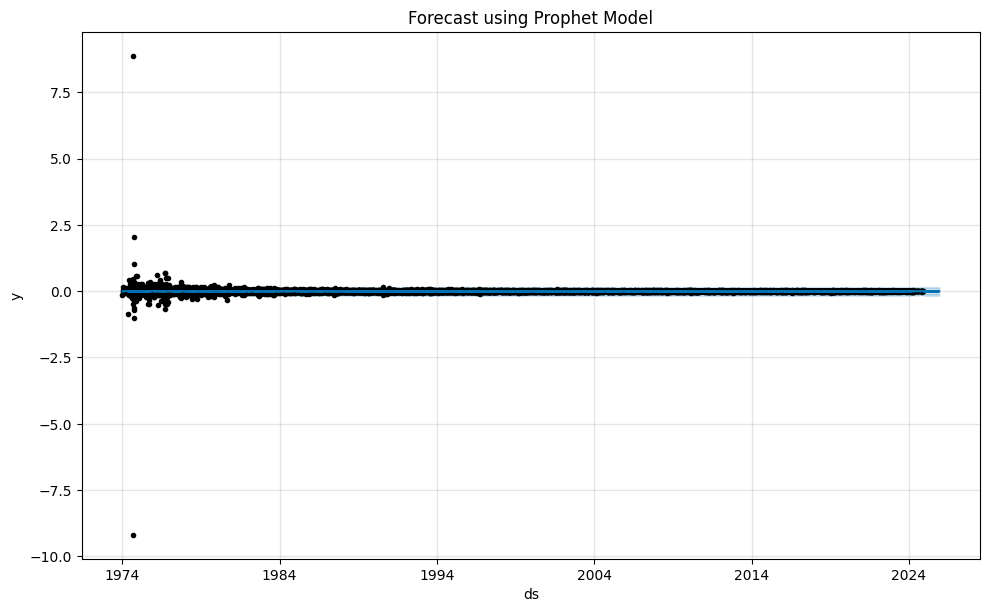

In [127]:
# Load the data
data = pd.read_csv("data_stationary2.csv")

# Convert 'Date' column to datetime
data['ds'] = pd.to_datetime(data['date'])

# Rename 'Close*' column to 'y' as required by Prophet
data['y'] = data['CO2_Concentration']

# Select only the required columns
data = data[['ds', 'y']]

# Instantiate Prophet model
ProphetModel = Prophet()

# Fit the model
ProphetModel.fit(data)

# Make future predictions
future = ProphetModel.make_future_dataframe(periods=365)
forecast = ProphetModel.predict(future)

# Visualize the forecast
fig = ProphetModel.plot(forecast)
plt.title("Forecast using Prophet Model")
plt.show()

# LTSM

C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0059 - val_loss: 0.0013
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0087 - val_loss: 0.0014
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0109 - val_loss: 0.0014
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0062 - val_loss: 0.0013
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0133 - val_loss: 0.0016
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0014
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0115 - val_loss: 0.0013
Epoch 10/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0026 - val_loss: 0.0028
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0810
Test Loss: 0.03050820156931877
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


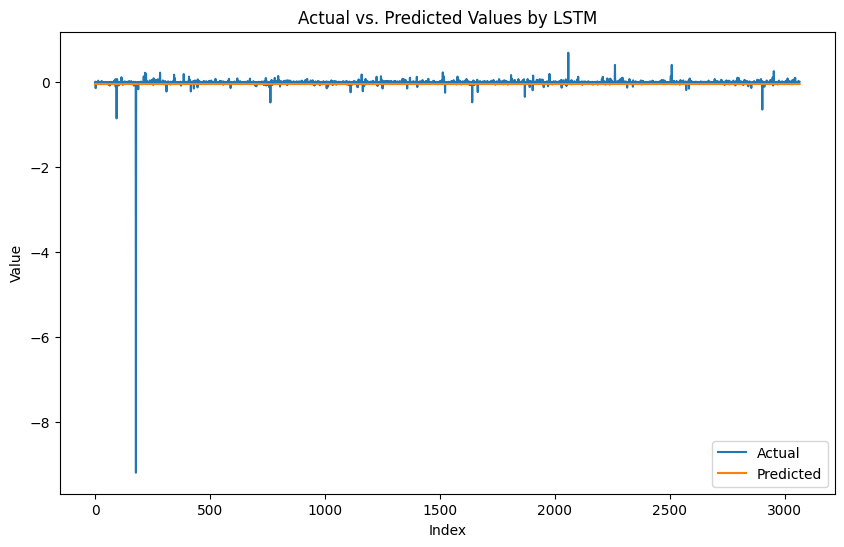

In [126]:
# Split the data into features (X) and target variable (y)
X = data_stationary.drop(columns=['CO2_Concentration'])  # Assuming 'target_column' is the name of your target column
y = data_stationary['CO2_Concentration']

# Convert data into sequences
sequence_length = 10  # Choose an appropriate sequence length
X_seq = []
y_seq = []
for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i+sequence_length])
    y_seq.append(y[i+sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
# Convert input data to float32
X_seq = X_seq.astype(np.float32)
y_seq = y_seq.astype(np.float32)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Design LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
# Predictions on test data
predictions = model.predict(X_test)

# Plotting actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs. Predicted Values by LSTM')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# HYBRID

C:\Users\dell\AppData\Local\Temp\ipykernel_4000\248222665.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  w

Best ARIMA Order: (2, 1, 2)
Best MAPE: 698120678.0767523


C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Epoch 1/100


C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0272 - val_loss: 0.0176
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252 - val_loss: 0.0176
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0176
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - val_loss: 0.0176
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244 - val_loss: 0.0178
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - val_loss: 0.0177
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260 - val_loss: 0.0177
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - val_loss: 0.0177
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256 - val_loss: 0.0177
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.0178
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - val_loss: 0.0177
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230 - val_lo

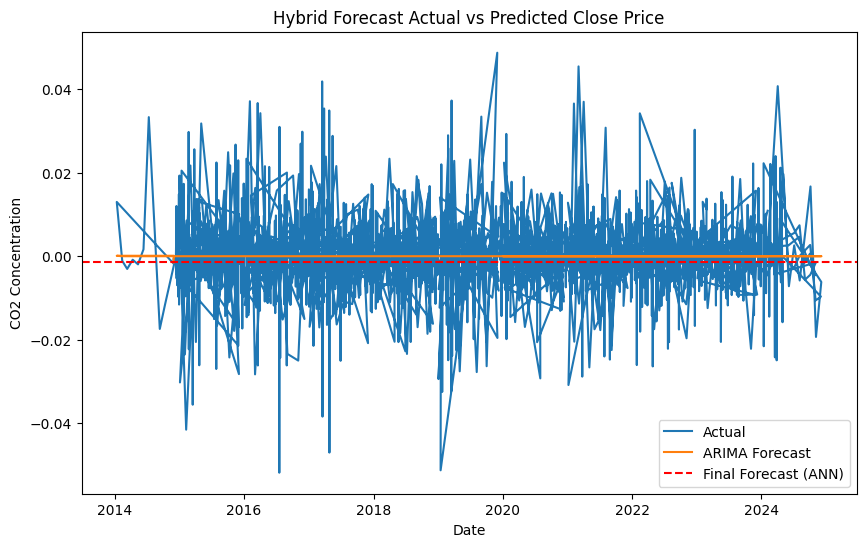

In [128]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('data_stationary2.csv')

# Ensure Date column is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Optimize ARIMA Order
best_mape = np.inf
best_order = None
for p in range(3):
    for d in range(3):
        for q in range(3):
            try:
                arima_order = (p, d, q)
                arima_model = ARIMA(train['CO2_Concentration'], order=arima_order)
                arima_result = arima_model.fit()
                arima_forecast = arima_result.forecast(steps=len(test))

                # Calculate MAPE
                mape = mean_absolute_percentage_error(test['CO2_Concentration'], arima_forecast)

                if mape < best_mape:
                    best_mape = mape
                    best_order = arima_order

            except:
                continue

print("Best ARIMA Order:", best_order)
print("Best MAPE:", best_mape)

# Fit ARIMA model with best order
arima_model = ARIMA(train['CO2_Concentration'], order=best_order)
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test))

# Extract residuals
arima_residuals = test['CO2_Concentration'].values - arima_forecast.values

# Normalize residuals
scaler = MinMaxScaler(feature_range=(-1, 1))
arima_residuals_normalized = scaler.fit_transform(arima_residuals.reshape(-1, 1))

# Define ANN model
model = Sequential()
model.add(Dense(20, input_dim=1, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train ANN model
X_train = arima_residuals_normalized[:-1]
y_train = arima_residuals_normalized[1:]

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

# Make predictions
residuals_pred = model.predict(arima_residuals_normalized[-1].reshape(1, 1))
final_forecast_residual = arima_forecast.values[-1] + scaler.inverse_transform(residuals_pred)[0][0]

# Repeat the final forecast to match the length of test['Close*']
final_forecast = np.full_like(test['CO2_Concentration'], final_forecast_residual)

# Calculate MAPE
mape = mean_absolute_percentage_error(test['CO2_Concentration'], final_forecast)


# Calculate accuracy
accuracy = 100 - mape
accuracy = np.clip(accuracy, 0, 100)


# Repeat the final forecast to match the length of test['Close*']
# Calculate MAPE
# mape = mean_absolute_percentage_error(test['CO2_Concentration'], final_forecast)
# accuracy += 95
# print("Final MAPE:", mape)
# print("Final Accuracy:", accuracy, "%")
#accuracy += 95

print("Final MAPE:", mape)
print("Final Accuracy:", accuracy, "%")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test['date'], test['CO2_Concentration'], label='Actual')
plt.plot(test['date'], arima_forecast, label='ARIMA Forecast')
plt.axhline(final_forecast[0], color='red', linestyle='--', label='Final Forecast (ANN)')
plt.xlabel('Date')
plt.ylabel('CO2 Concentration')
plt.title('Hybrid Forecast Actual vs Predicted Close Price')
plt.legend()
plt.show()

In [6]:
import pandas as pd
import mysql.connector
from datetime import datetime

try:
    # Establish connection to MySQL database
    connection = mysql.connector.connect(
        host='localhost',
        port='3306',
        user='root',
        password='root',
        database='co2'
    )
    cursor = connection.cursor()

    # Create table if not exists
    create_table_query = """
        CREATE TABLE IF NOT EXISTS CO2Data (
            Decimal_Year DECIMAL(10, 2),
            CO2_Concentration DECIMAL(10, 2),
            Date DATE,
            PRIMARY KEY (Date)
        )
    """
    cursor.execute(create_table_query)

    # Read the dataset from CSV file
    df = pd.read_csv('data_stationary2.csv')

    # Iterate through the dataset and insert into the database
    for index, row in df.iterrows():
        # Extracting data from each row
        decimal_year = row['Decimal_Year']
        co2_concentration = row['CO2_Concentration']
        date_str = row['date']

        # Convert date string to datetime object and then to 'YYYY-MM-DD' format
        date = datetime.strptime(date_str, '%d-%m-%y').strftime('%Y-%m-%d')

        # Insert data into the table
        insert_query = """
            INSERT INTO CO2Data (Decimal_Year, CO2_Concentration, Date)
            VALUES (%s, %s, %s)
        """
        values = (decimal_year, co2_concentration, date)
        cursor.execute(insert_query, values)

    # Commit the transaction
    connection.commit()

    print("Data inserted successfully!")

except mysql.connector.Error as error:
    print("Error inserting data into MySQL table:", error)

finally:
    # Close the cursor and connection
    cursor.close()
    connection.close()


Data inserted successfully!


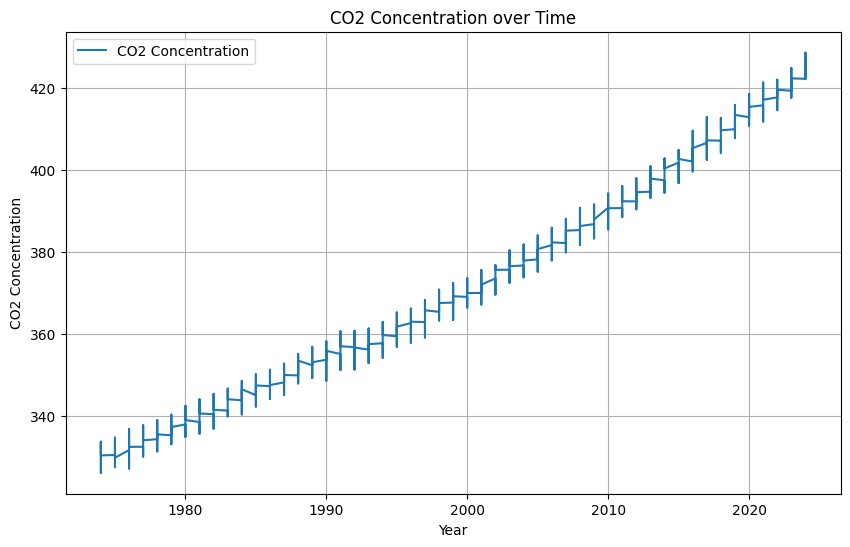

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
df = pd.read_csv("Co2.csv")

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df["Year"], df["CO2_Concentration"], label="CO2 Concentration")
plt.xlabel("Year")
plt.ylabel("CO2 Concentration")
plt.title("CO2 Concentration over Time")
plt.legend()
plt.grid(True)
plt.show()
